# Stability calculations

## -- LUVOIR --

In notebook 10, we calculated the PASTIS modes for all three currently designed apodizers for the LUVOIR A pupil. In this notebook, we will load the modes and calculate the maximum mode contributions $\sigma$ and strability requirements $\Delta \sigma$.

After that I also calculate the maximum segment contributions $\mu$.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import hcipy as hc

os.chdir('../../pastis/')
import util_pastis as util
from e2e_simulators.luvoir_imaging_new import LuvoirAPLC

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

## Instantiate a simple SM for mode plotting

I need to simplify this... I can make a child class like I did for the full LUVOIR simulator.

In [3]:
# Load aperture files needed for SM
nseg = 120
wvln = 638e-9

datadir = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
aper_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))

pupil_grid = hc.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hc.Field(aper_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)

wf_aper = hc.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nseg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hc.CartesianGrid(hc.UnstructuredCoords(poslist))

## Mode and eigenvalue units

Since the matrices got generated normalized to an aberration of 1 nm, everything stemming from the matrix will be in units of **nanometers**. --> This is the desired behaviour of course and is yet to be confirmed, which is one of the goals of this notebook.

In [4]:
eunit = 1e-9

## Also instantiate a LUVOR telescope

For cumulative contrast calculation.

> **ATTENTION:** the variable `apodizer_design` has to be correct for the data we are reading with the variable `savedpath` further below!!!

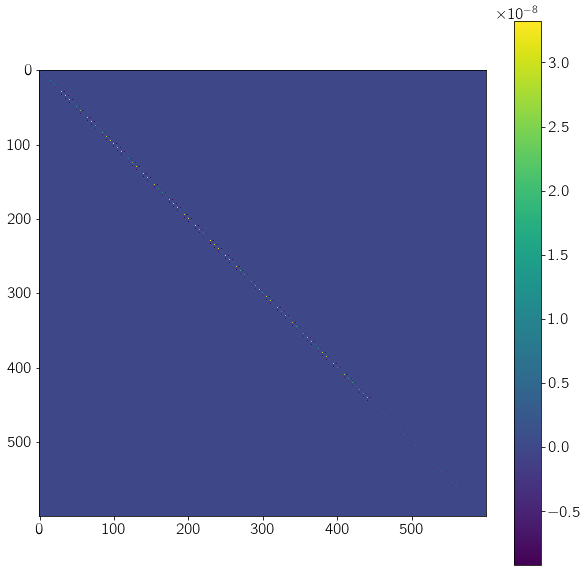

In [5]:
savedpath = '/Users/pueyo/Documents/data_from_repos/pastis_data/2020-06-22T14-01-35_luvoir-medium'   # large apodizer LUVOIR
matrix = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'PASTISmatrix_num_Multiple_Modes_Harris_Thermal.fits'))
plt.figure(figsize=(10, 10))
plt.imshow(matrix)
plt.colorbar()

In [6]:
# Instantiate LUVOIR
sampling = 4
apodizer_design = 'medium'
# This path is specific to the paths used in the LuvoirAPLC class
optics_input = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
luvoir = LuvoirAPLC(optics_input, apodizer_design, sampling)

/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:68: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


In [7]:
Pad_orients = np.pi / 2 * np.ones(120)
harris_file = '/Users/pueyo/Desktop/ULTRA/HarrisData/Sensitivities2.xlsx'
luvoir.make_segment_Harris_thermal_primary(harris_file, Pad_orients)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


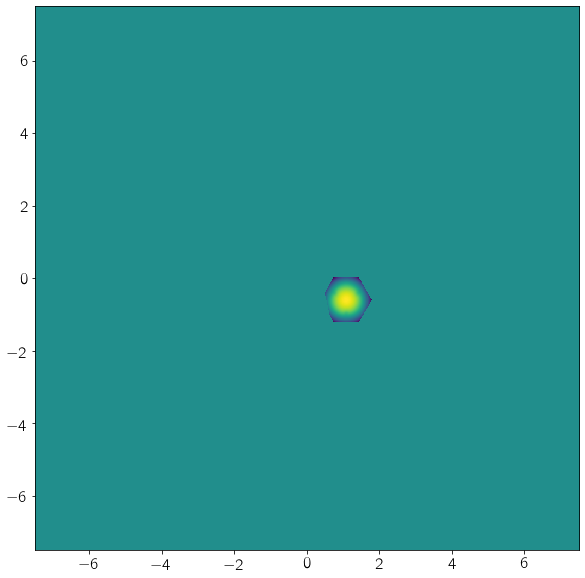

In [8]:
zernike_coeffs = np.zeros([5*120])
zernike_coeffs[4] = eunit
luvoir.sm.actuators = zernike_coeffs
wf_sm = luvoir.sm(luvoir.wf_aper)
plt.figure(figsize=(10, 10))
hc.imshow_field(wf_sm.phase)

In [9]:
zernike_coeffs = np.zeros([5*120])
zernike_coeffs[4] = 0
luvoir.sm.actuators = zernike_coeffs
wf_sm = luvoir.sm(luvoir.wf_aper)
psf_unaber, ref = luvoir.calc_psf(ref=True)
norm = ref.max()

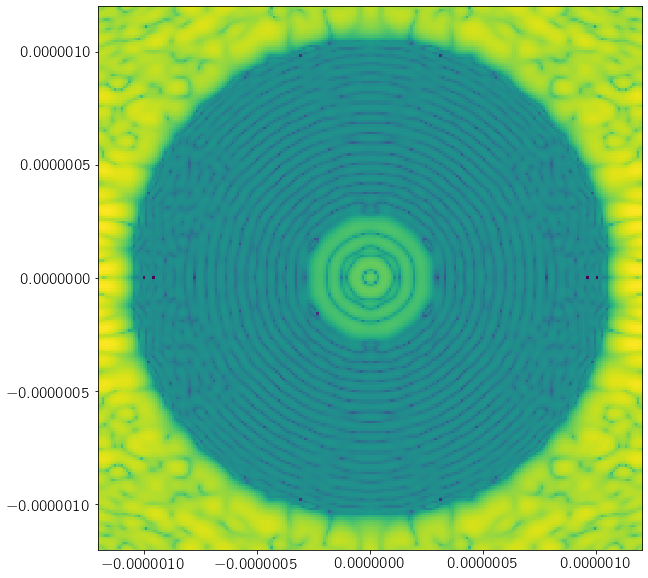

In [10]:
psf_unaber, ref = luvoir.calc_psf(ref=True)
norm = ref.max()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber, norm=LogNorm())

In [11]:
# Make dark hole
dh_outer = hc.circular_aperture(2*luvoir.apod_dict[apodizer_design]['owa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_inner = hc.circular_aperture(2*luvoir.apod_dict[apodizer_design]['iwa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_mask = (dh_outer - dh_inner).astype('bool')

In [12]:
dh_intensity = psf_unaber/norm * dh_mask
baseline_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
print('contrast:', baseline_contrast)

contrast: 3.924822663883738e-11


## Read eigenmodes and eigenvalues

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


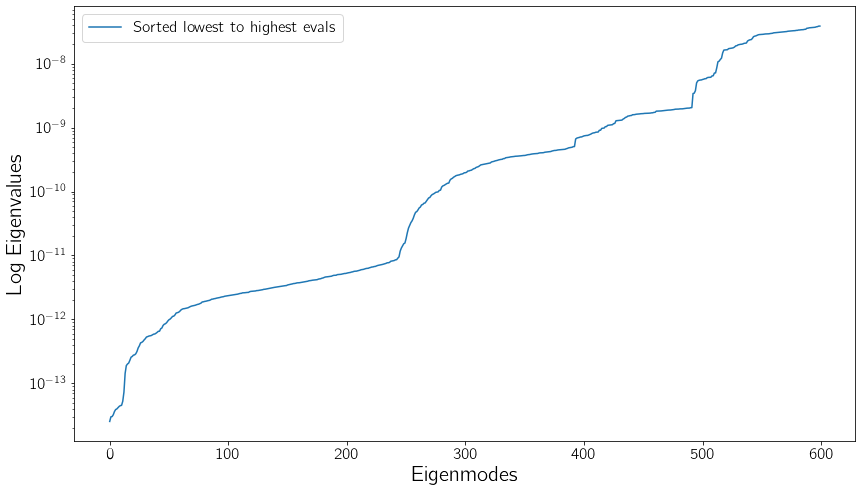

In [13]:
evals, evecs = np.linalg.eig(matrix)
sorted_evals = np.sort(evals)
sorted_indices = np.argsort(evals)
sorted_evecs = evecs[:, sorted_indices]
plt.figure(figsize=(14, 8))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evals, label='Sorted lowest to highest evals')
plt.semilogy()
plt.xlabel('Eigenmodes')
plt.ylabel('Log Eigenvalues')
plt.legend()

In [14]:
# Lets compute all modes now for LUVOIR with an HCIPy SM
emodes = []

for mode in range(len(evals)):
    print('Working on mode {}/{}.'.format(mode+1, len(evals)))
    
    zernike_coeffs = eunit*sorted_evecs[:, mode]/2
    luvoir.sm.actuators = zernike_coeffs
    wf_sm = luvoir.sm(luvoir.wf_aper)
    emodes.append(wf_sm.phase)

Working on mode 1/600.
Working on mode 2/600.
Working on mode 3/600.
Working on mode 4/600.
Working on mode 5/600.
Working on mode 6/600.
Working on mode 7/600.
Working on mode 8/600.
Working on mode 9/600.
Working on mode 10/600.
Working on mode 11/600.
Working on mode 12/600.
Working on mode 13/600.
Working on mode 14/600.
Working on mode 15/600.
Working on mode 16/600.
Working on mode 17/600.
Working on mode 18/600.
Working on mode 19/600.
Working on mode 20/600.
Working on mode 21/600.
Working on mode 22/600.
Working on mode 23/600.
Working on mode 24/600.
Working on mode 25/600.
Working on mode 26/600.
Working on mode 27/600.
Working on mode 28/600.
Working on mode 29/600.
Working on mode 30/600.
Working on mode 31/600.
Working on mode 32/600.
Working on mode 33/600.
Working on mode 34/600.
Working on mode 35/600.
Working on mode 36/600.
Working on mode 37/600.
Working on mode 38/600.
Working on mode 39/600.
Working on mode 40/600.
Working on mode 41/600.
Working on mode 42/600.
W

Working on mode 334/600.
Working on mode 335/600.
Working on mode 336/600.
Working on mode 337/600.
Working on mode 338/600.
Working on mode 339/600.
Working on mode 340/600.
Working on mode 341/600.
Working on mode 342/600.
Working on mode 343/600.
Working on mode 344/600.
Working on mode 345/600.
Working on mode 346/600.
Working on mode 347/600.
Working on mode 348/600.
Working on mode 349/600.
Working on mode 350/600.
Working on mode 351/600.
Working on mode 352/600.
Working on mode 353/600.
Working on mode 354/600.
Working on mode 355/600.
Working on mode 356/600.
Working on mode 357/600.
Working on mode 358/600.
Working on mode 359/600.
Working on mode 360/600.
Working on mode 361/600.
Working on mode 362/600.
Working on mode 363/600.
Working on mode 364/600.
Working on mode 365/600.
Working on mode 366/600.
Working on mode 367/600.
Working on mode 368/600.
Working on mode 369/600.
Working on mode 370/600.
Working on mode 371/600.
Working on mode 372/600.
Working on mode 373/600.


## Segment based constraints

In [15]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

In [16]:
c_target = 1e-10

In [17]:
number_of_modes = luvoir.sm.num_actuators
# Calculate the inverse of the pastis MODE matrix
modestosegs = np.linalg.pinv(sorted_evecs)

# # Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
# c_avg = []
# for i in range(number_of_modes):
#     c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) + baseline_contrast)

# # Calculate segment requirements
# mu_map = np.sqrt(
#     ((c_target - baseline_contrast) / number_of_modes) / (np.dot(c_avg - baseline_contrast, np.square(modestosegs))))

# Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
c_avg = []
for i in range(number_of_modes):
    c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) )

# Calculate segment requirements
mu_map = np.sqrt(
    ((c_target ) / number_of_modes) / (np.dot(c_avg, np.square(modestosegs))))

In [18]:
zernike_coeffs = np.zeros([5*120])
luvoir.sm.actuators = zernike_coeffs
wf_sm = luvoir.sm(luvoir.wf_aper)
psf_unaber, ref, inter_unaber = luvoir.calc_psf(ref=True, return_intermediate='efield')

contrast: 5.377626204159006e-11


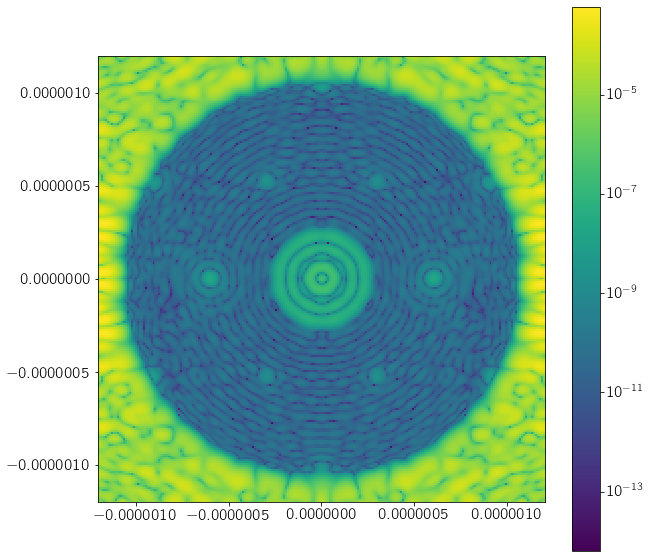

In [19]:
zernike_coeffs = mu_map*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf.intensity/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = np.abs(psf.electric_field - psf_unaber.electric_field)**2/norm 
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
print('contrast:', test_contrast)

In [20]:
N_zernike = 5
zernike_coeffs_numaps_Drifts = np.zeros([N_zernike,120])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([120])
    for pp in range(120):
        zernike_coeffs_tmp[pp] = mu_map[qq+(pp)*N_zernike]
    zernike_coeffs_numaps_Drifts[qq] = zernike_coeffs_tmp

In [21]:
N_zernike = 5
zernike_coeffs_numaps = np.zeros([N_zernike,number_of_modes])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([number_of_modes])
    for pp in range(120):
        zernike_coeffs_tmp[qq+(pp)*N_zernike] = mu_map[qq+(pp)*N_zernike]
    zernike_coeffs_numaps[qq] = zernike_coeffs_tmp

In [22]:
# Instantiate LUVOIR
sampling = 4
apodizer_design = 'medium'
# This path is specific to the paths used in the LuvoirAPLC class
optics_input = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
luvoirDUMMY = LuvoirAPLC(optics_input, apodizer_design, sampling)
luvoirDUMMY.make_segment_zernike_primary(1)

/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:68: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [23]:
luvoirDUMMY.wf_aper.wavenumber*eunit

0.009848252832569885

In [24]:
nu_maps = []
for qq in range(N_zernike):
    zernike_coeffs = eunit*zernike_coeffs_numaps[qq]/2
    luvoir.sm.actuators = zernike_coeffs
    nu_maps.append(luvoir.sm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber)

In [25]:
nu_maps_Drifts = []
for qq in range(N_zernike):
    zernike_coeffs = eunit*zernike_coeffs_numaps_Drifts[qq]/2
    luvoirDUMMY.sm.actuators = zernike_coeffs
    nu_maps_Drifts.append(luvoirDUMMY.sm(luvoirDUMMY.wf_aper).phase/luvoirDUMMY.wf_aper.wavenumber/eunit)

Text(0.5, 1, 'Segment')

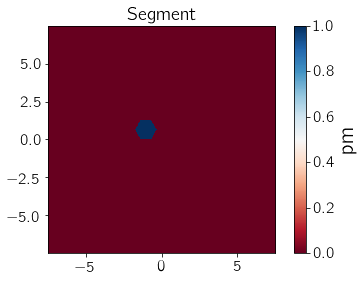

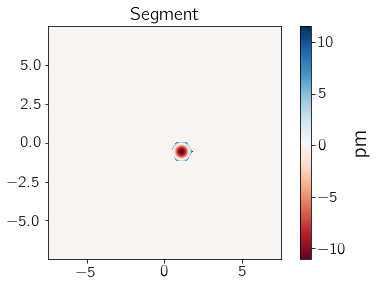

In [26]:
zernike_coeffs = np.zeros([120])
zernike_coeffs[3] = eunit/2
luvoirDUMMY.sm.actuators = zernike_coeffs
tost = luvoirDUMMY.sm(luvoirDUMMY.wf_aper).phase/luvoirDUMMY.wf_aper.wavenumber/eunit
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(tost, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment')
zernike_coeffs = np.zeros([5*120])
zernike_coeffs[0] = eunit/2
luvoir.sm.actuators = zernike_coeffs
tast = luvoir.sm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber/eunit
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(tast, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment')

In [27]:
# zernike_coeffs = np.zeros([5*120])
# zernike_coeffs[0] = 1e-12/2
# luvoir.sm.actuators = zernike_coeffs
# tast = luvoir.sm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber/1e-12
# fig, ax = plt.subplots(ncols=1)
# img1 = hc.imshow_field(tast, cmap='RdBu')#, vmin=pmin, vmax=pmax)
# clb = fig.colorbar(img1)
# clb.set_label('pm', rotation=90)
# plt.tight_layout(h_pad=1)
# plt.title('Segment')

contrast: 2.453001582971368e-11


Text(0.5, 1, 'Faceplates Silvered ')

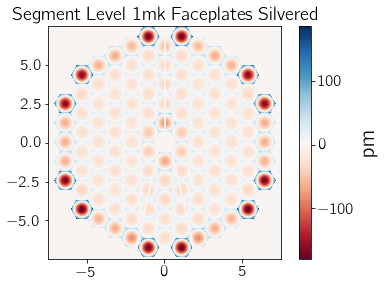

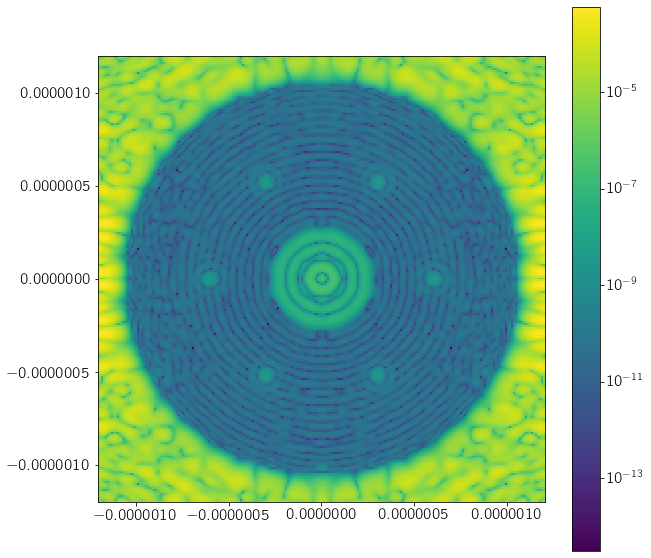

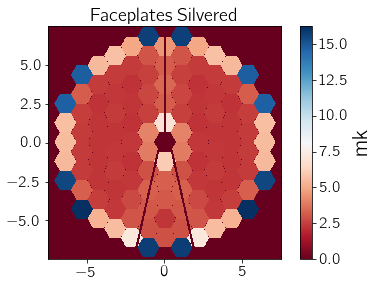

In [28]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk Faceplates Silvered ')
zernike_coeffs = zernike_coeffs_numaps[0]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])- baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_Drifts[0]*1000,cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('mk', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Faceplates Silvered ')

contrast: 7.635890709270725e-12


Text(0.5, 1, 'Bulk')

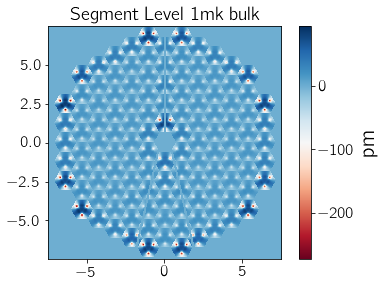

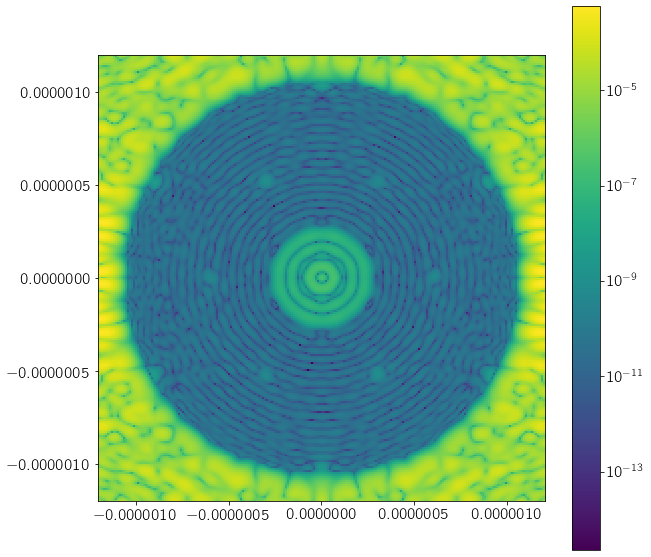

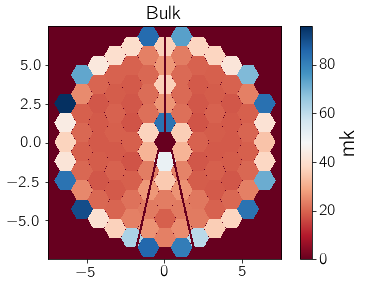

In [29]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[1]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk bulk ')
zernike_coeffs = zernike_coeffs_numaps[1]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_Drifts[1]*1000,cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('mk', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Bulk')

contrast: 2.189115253912212e-11


Text(0.5, 1, 'Gradiant radial')

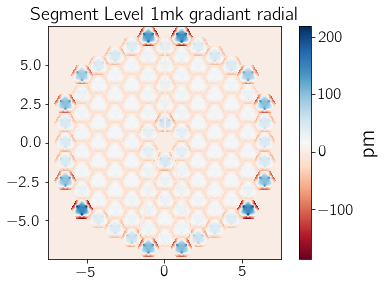

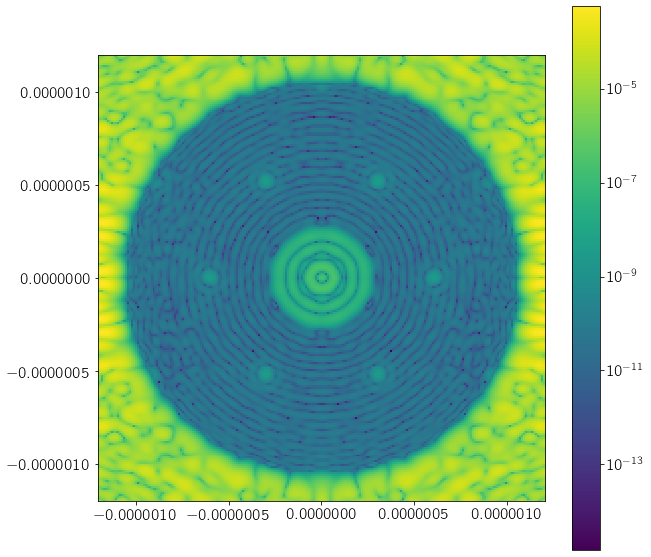

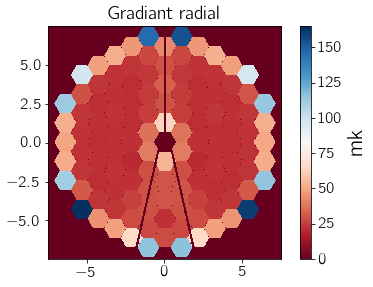

In [30]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[2]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk gradiant radial')
zernike_coeffs = zernike_coeffs_numaps[2]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_Drifts[2]*1000,cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('mk', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Gradiant radial')

contrast: 1.9979323258182413e-11


Text(0.5, 1, 'Gradient X lateral')

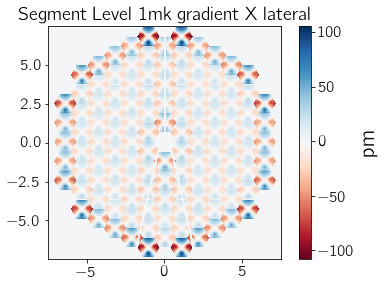

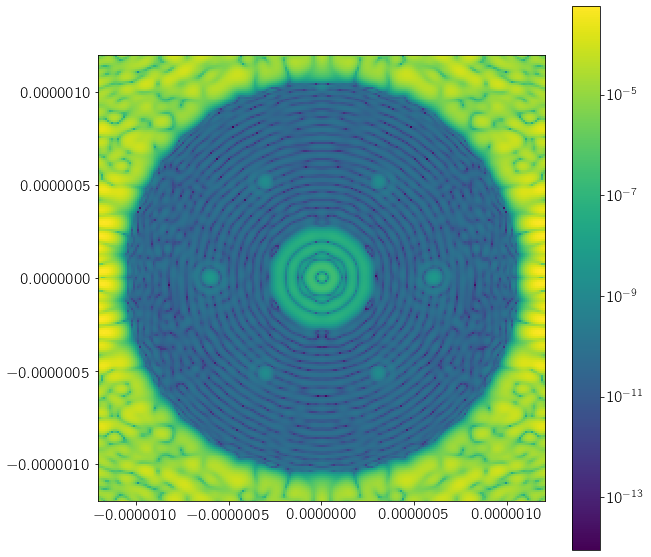

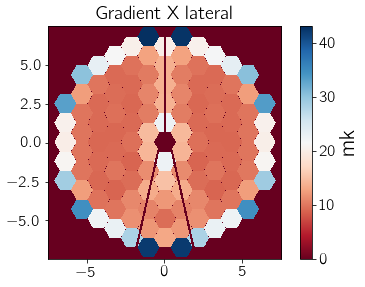

In [31]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[3]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk gradient X lateral  ')
zernike_coeffs = zernike_coeffs_numaps[3]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_Drifts[3]*1000,cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('mk', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Gradient X lateral')

contrast: 1.9979323258182413e-11


Text(0.5, 1, 'Gradient Z axial')

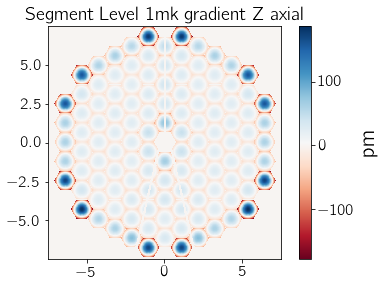

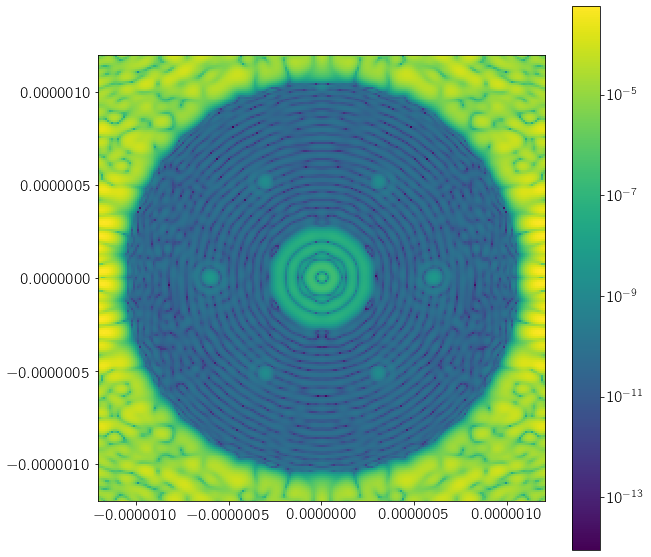

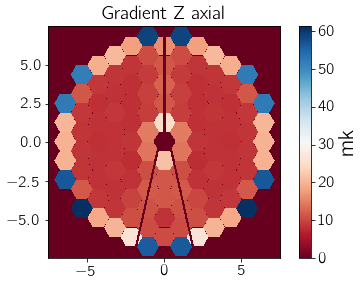

In [32]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[4]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk gradient Z axial')
zernike_coeffs = zernike_coeffs_numaps[3]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_Drifts[4]*1000,cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('mk', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Gradient Z axial')

# Drawing the modes

In [33]:
import pandas as pd 
from scipy.interpolate import griddata

Text(0.5, 1, 'Segment Level 1mk gradient Z axial')

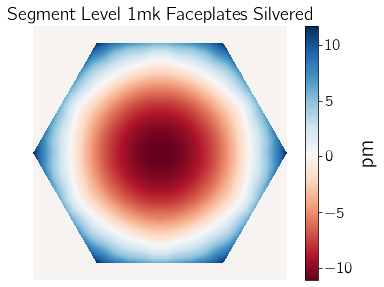

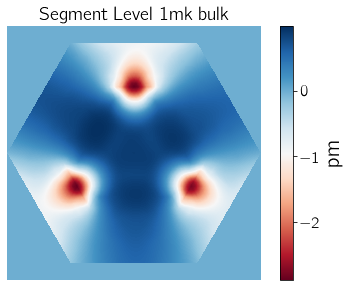

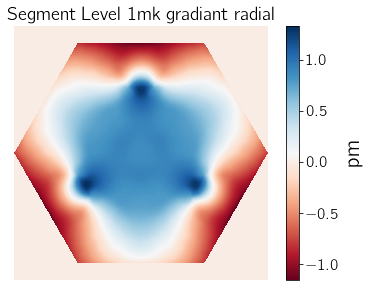

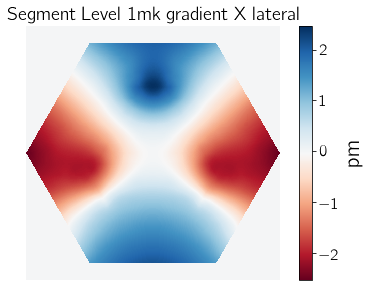

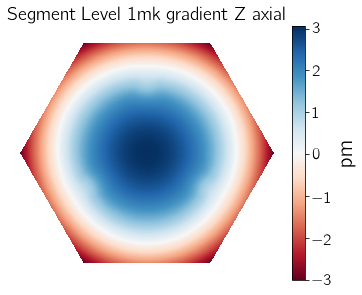

In [34]:
df = pd.read_excel(harris_file)
#Thermal: a, h, i, j, k  
#Mechnical: e, f, g
#Other: b, c, d
X = np.asarray(df.X)
Y = np.asarray(df.Y)
A = np.asarray(df.a)
B = np.asarray(df.b)
C = np.asarray(df.c)
D = np.asarray(df.d)
E = np.asarray(df.e)
F = np.asarray(df.f)
G = np.asarray(df.g)
H = np.asarray(df.h)
I = np.asarray(df.i)
J = np.asarray(df.j)
K = np.asarray(df.k)
# ti = np.linspace(-1,1,200)
# XI, YI = np.meshgrid(ti, ti)
# points = np.transpose(np.asarray([X,Y]))
# values = A
# ZI = griddata(points, values, (XI, YI), method='linear')
# f = plt.figure()
# plt.imshow(ZI)
# plt.clim(min(A),max(A))
# plt.colorbar()
# phi = np.pi/2
# XRot = XI * np.cos(phi) + YI * np.sin(phi)
# YRot = -XI * np.sin(phi) + YI * np.cos(phi)
# pointsR = np.transpose(np.asarray([X,Y]))
# values = A
# ZI = griddata(pointsR, values, (XRot, YRot), method='linear')
# f = plt.figure()
# plt.imshow(ZI)
# plt.clim(min(A),max(A))
# plt.colorbar()
X = np.asarray(df.X)
Y = np.asarray(df.Y)
HarrisDiam = np.max([np.max(X)-np.min(X),np.max(Y)-np.min(Y)])
pup_dims = luvoir.pupil_grid.dims
X = np.asarray(df.X)*luvoir.diam/HarrisDiam
Y = np.asarray(df.Y)*luvoir.diam/HarrisDiam
ti = np.linspace(-0.5,0.5,pup_dims[0])*luvoir.diam
points = np.transpose(np.asarray([X,Y]))
valuesA = A
valuesB = B
valuesC = C
valuesD = D
valuesE = E
valuesF = F
valuesG = G
valuesH = H
valuesI = I
valuesJ = J
valuesK = K
XI, YI = np.meshgrid(ti, ti)
# ZI = griddata(points, valuesA, (XI, YI), method='linear')
# ZI[np.isnan(ZI)]=0
# f = plt.figure()
# plt.imshow(ZI)
# plt.clim(min(A),max(A))
# plt.colorbar()
phi = np.pi/2
pointsR = np.transpose(np.asarray([X,Y]))
XRot = XI * np.cos(phi) + YI * np.sin(phi)
YRot = -XI * np.sin(phi) + YI * np.cos(phi)
ZA = griddata(points, valuesA, (XRot, YRot), method='linear')
ZA[np.isnan(ZA)]=0
# ZA = ZA.ravel()
ZH = griddata(points, valuesH, (XRot, YRot), method='linear')
ZH[np.isnan(ZH)]=0
# ZH = ZH.ravel()
ZI = griddata(points, valuesI, (XRot, YRot), method='linear')
ZI[np.isnan(ZI)]=0
# ZI = ZI.ravel()
ZJ = griddata(points, valuesJ, (XRot, YRot), method='linear')
ZJ[np.isnan(ZJ)]=0
# ZJ = ZJ.ravel()
ZK = griddata(points, valuesK, (XRot, YRot), method='linear')
# ZK[np.isnan(ZK)]=0
fig, ax = plt.subplots(ncols=1)
img1 = plt.imshow(ZA, cmap='RdBu')#, vmin=pmin, vmax=pmax)
plt.axis('off')
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk Faceplates Silvered')
fig, ax = plt.subplots(ncols=1)
img2 = plt.imshow(ZH, cmap='RdBu')#, vmin=pmin, vmax=pmax)
plt.axis('off')
clb = fig.colorbar(img2)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk bulk')
fig, ax = plt.subplots(ncols=1)
img3 = plt.imshow(ZI, cmap='RdBu')#, vmin=pmin, vmax=pmax)
plt.axis('off')
clb = fig.colorbar(img3)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk gradiant radial')
fig, ax = plt.subplots(ncols=1)
img4 = plt.imshow(ZJ, cmap='RdBu')#, vmin=pmin, vmax=pmax)
plt.axis('off')
clb = fig.colorbar(img4)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk gradient X lateral')
fig, ax = plt.subplots(ncols=1)
img5 = plt.imshow(ZK, cmap='RdBu')#, vmin=pmin, vmax=pmax)
plt.axis('off')
clb = fig.colorbar(img5)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level 1mk gradient Z axial')

# E2E histogram

In [35]:
n_repeat = 3000
all_contr_rand_seg = []
all_random_maps = []
for rep in range(n_repeat):
    print('Segment realization {}/{}'.format(rep + 1, n_repeat))
    #zernike_coeffs = np.random.uniform(-mu_map*eunit,mu_map*eunit,number_of_modes)
    zernike_coeffs = np.random.uniform(0,mu_map*eunit,number_of_modes)
    luvoir.sm.actuators = zernike_coeffs
    luvoir.sm(luvoir.wf_aper)
    psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield')
#     plt.figure(figsize=(10, 10))
#     hc.imshow_field(psf.intensity/norm, norm=LogNorm())
#     plt.colorbar()
    dh_intensity = np.abs(psf.electric_field - psf_unaber.electric_field)**2/norm 
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
    all_contr_rand_seg.append(test_contrast) 
    print('contrast:', test_contrast)
    

Segment realization 1/3000
contrast: 7.397373408827434e-11
Segment realization 2/3000
contrast: 7.400943885562011e-11
Segment realization 3/3000
contrast: 7.791283924373227e-11
Segment realization 4/3000
contrast: 7.221795934426102e-11
Segment realization 5/3000
contrast: 7.992385358456207e-11
Segment realization 6/3000
contrast: 7.484487424550544e-11
Segment realization 7/3000
contrast: 7.266086691814985e-11
Segment realization 8/3000
contrast: 6.864180175133549e-11
Segment realization 9/3000
contrast: 8.058806284255243e-11
Segment realization 10/3000
contrast: 6.952310959996975e-11
Segment realization 11/3000
contrast: 6.737391821636078e-11
Segment realization 12/3000
contrast: 7.137856420810127e-11
Segment realization 13/3000
contrast: 8.11158190829201e-11
Segment realization 14/3000
contrast: 6.734382253678361e-11
Segment realization 15/3000
contrast: 7.056797644120938e-11
Segment realization 16/3000
contrast: 7.305392539824748e-11
Segment realization 17/3000
contrast: 8.4737984539

contrast: 7.476157983081658e-11
Segment realization 138/3000
contrast: 8.366691699301723e-11
Segment realization 139/3000
contrast: 6.339186680275732e-11
Segment realization 140/3000
contrast: 7.605746234853123e-11
Segment realization 141/3000
contrast: 7.66678857718893e-11
Segment realization 142/3000
contrast: 7.749509393997533e-11
Segment realization 143/3000
contrast: 7.733818085067403e-11
Segment realization 144/3000
contrast: 7.827176153209258e-11
Segment realization 145/3000
contrast: 7.80048528992698e-11
Segment realization 146/3000
contrast: 7.061591237832395e-11
Segment realization 147/3000
contrast: 7.197494032141035e-11
Segment realization 148/3000
contrast: 6.818822622664278e-11
Segment realization 149/3000
contrast: 8.017436331950571e-11
Segment realization 150/3000
contrast: 8.250323764666172e-11
Segment realization 151/3000
contrast: 7.936214503708446e-11
Segment realization 152/3000
contrast: 7.820669145494824e-11
Segment realization 153/3000
contrast: 6.59715936527009

contrast: 7.661226945189212e-11
Segment realization 273/3000
contrast: 7.115913391175338e-11
Segment realization 274/3000
contrast: 7.980991046461285e-11
Segment realization 275/3000
contrast: 7.929382815146065e-11
Segment realization 276/3000
contrast: 7.653369423419026e-11
Segment realization 277/3000
contrast: 8.474940402281677e-11
Segment realization 278/3000
contrast: 7.695831788743648e-11
Segment realization 279/3000
contrast: 7.289065949189914e-11
Segment realization 280/3000
contrast: 7.552479696329279e-11
Segment realization 281/3000
contrast: 6.82676317044384e-11
Segment realization 282/3000
contrast: 7.49275783073348e-11
Segment realization 283/3000
contrast: 7.023025504119715e-11
Segment realization 284/3000
contrast: 6.85010915717893e-11
Segment realization 285/3000
contrast: 6.975667648386638e-11
Segment realization 286/3000
contrast: 6.939674589019826e-11
Segment realization 287/3000
contrast: 6.25317527937394e-11
Segment realization 288/3000
contrast: 7.707794365158435e

contrast: 7.7231558850919e-11
Segment realization 408/3000
contrast: 7.577635589197059e-11
Segment realization 409/3000
contrast: 7.281236695056357e-11
Segment realization 410/3000
contrast: 7.549951609760319e-11
Segment realization 411/3000
contrast: 8.555573023778284e-11
Segment realization 412/3000
contrast: 8.033944282611862e-11
Segment realization 413/3000
contrast: 6.517205626114534e-11
Segment realization 414/3000
contrast: 7.254435624576871e-11
Segment realization 415/3000
contrast: 6.841369015253058e-11
Segment realization 416/3000
contrast: 7.977059311482968e-11
Segment realization 417/3000
contrast: 7.311912813189283e-11
Segment realization 418/3000
contrast: 7.221786778400754e-11
Segment realization 419/3000
contrast: 7.359287192402273e-11
Segment realization 420/3000
contrast: 6.950424841373876e-11
Segment realization 421/3000
contrast: 7.628896028741627e-11
Segment realization 422/3000
contrast: 7.011103250363939e-11
Segment realization 423/3000
contrast: 7.43076545675916

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16, 10))
plt.hist(all_contr_rand_seg,30)
plt.title('E2E raw contrast, {} realizations, target contrast 1e-10'.format(n_repeat), size=20)
plt.xlabel('Mean contrast in DH', size=20)
plt.ylabel('PDF', size=20)
plt.tick_params(axis='both', which='both', length=6, width=2, labelsize=25)

In [ ]:
x